# Set up the class fundementals 

In [1]:
import warnings

warnings.filterwarnings('ignore')
# import os, sys
# import collections
import numpy as _np
# import matplotlib.markers as markers
# import matplotlib.pyplot as plt
# import timeit
# import collections
# from scipy.stats import median_abs_deviation as mad
# import multiprocessing
# import cProfile
# import itertools
from numba import jit as _jit
from numba import njit as _njit
# import warnings
# warnings.filterwarnings('ignore') # this is just to hide all the warnings
# import rpy2.robjects as robjects
# import matplotlib.pyplot as plt # change font globally to Times
# plt.style.use('ggplot')
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times New Roman",
#     "font.sans-serif": ["Times New Roman"],
#     "font.size": 12})

# os.chdir(sys.path[0]) # ensure working direcotry is set same as the file

In [2]:
######################################  some SCAD and MCP things  #######################################
@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def soft_thresholding(x, lambda_):
    '''
    To calculate soft-thresholding mapping of a given ONE-DIMENSIONAL tensor, BESIDES THE FIRST TERM (so beta_0 will not be penalized). 
    This function is to be used for calculation involving L1 penalty term later. 
    '''
    return _np.hstack((_np.array([x[0]]),
                       _np.where(
                           _np.abs(x[1:]) > lambda_,
                           x[1:] - _np.sign(x[1:]) * lambda_, 0)))


soft_thresholding(_np.random.rand(20), 3.1)


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD(x, lambda_, a=3.7):
    '''
    To calculate SCAD penalty value;
    #x can be a multi-dimensional tensor;
    lambda_, a are scalars;
    Fan and Li suggests to take a as 3.7 
    '''
    # here I notice the function is de facto a function of absolute value of x, therefore take absolute value first to simplify calculation
    x = _np.abs(x)
    temp = _np.where(
        x <= lambda_, lambda_ * x,
        _np.where(x < a * lambda_,
                  (2 * a * lambda_ * x - x**2 - lambda_**2) / (2 * (a - 1)),
                  lambda_**2 * (a + 1) / 2))
    temp[0] = 0.  # this is to NOT penalize intercept beta later
    return temp


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD_grad(x, lambda_, a=3.7):
    '''
    To calculate the gradient of SCAD wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    # here decompose x to sign and its absolute value for easier calculation
    sgn = _np.sign(x)
    x = _np.abs(x)
    temp = _np.where(
        x <= lambda_, lambda_ * sgn,
        _np.where(x < a * lambda_, (a * lambda_ * sgn - sgn * x) / (a - 1), 0))
    temp[0] = 0.  # this is to NOT penalize intercept beta later
    return temp


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP(x, lambda_, gamma):
    '''
    To calculate MCP penalty value; 
    #x can be a multi-dimensional tensor. 
    '''
    # the function is a function of absolute value of x
    x = _np.abs(x)
    temp = _np.where(x <= gamma * lambda_, lambda_ * x - x**2 / (2 * gamma),
                     .5 * gamma * lambda_**2)
    temp[0] = 0.  # this is to NOT penalize intercept beta later
    return temp


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP_grad(x, lambda_, gamma):
    '''
    To calculate MCP gradient wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    temp = _np.where(
        _np.abs(x) < gamma * lambda_,
        lambda_ * _np.sign(x) - x / gamma, _np.zeros_like(x))
    temp[0] = 0.  # this is to NOT penalize intercept beta later
    return temp


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD_concave(x, lambda_, a=3.7):
    '''
    The value of concave part of SCAD penalty; 
    #x can be a multi-dimensional tensor. 
    '''
    x = _np.abs(x)
    temp = _np.where(
        x <= lambda_, 0.,
        _np.where(x < a * lambda_,
                  (lambda_ * x - (x**2 + lambda_**2) / 2) / (a - 1),
                  (a + 1) / 2 * lambda_**2 - lambda_ * x))
    temp[0] = 0.  # this is to NOT penalize intercept beta later
    return temp


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def SCAD_concave_grad(x, lambda_, a=3.7):
    '''
    The gradient of concave part of SCAD penalty wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    sgn = _np.sign(x)
    x = _np.abs(x)
    temp = _np.where(
        x <= lambda_, 0.,
        _np.where(x < a * lambda_, (lambda_ * sgn - sgn * x) / (a - 1),
                  -lambda_ * sgn))
    temp[0] = 0.  # this is to NOT penalize intercept beta later
    return temp


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP_concave(x, lambda_, gamma):
    '''
    The value of concave part of MCP penalty; 
    #x can be a multi-dimensional tensor. 
    '''
    # similiar as in MCP
    x = _np.abs(x)
    temp = _np.where(x <= gamma * lambda_, -(x**2) / (2 * gamma),
                     (gamma * lambda_**2) / 2 - lambda_ * x)
    temp[0] = 0.  # this is to NOT penalize intercept beta later
    return temp


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def MCP_concave_grad(x, lambda_, gamma):
    '''
    The gradient of concave part of MCP penalty wrt. input x; 
    #x can be a multi-dimensional tensor. 
    '''
    temp = _np.where(
        _np.abs(x) < gamma * lambda_, -x / gamma, -lambda_ * _np.sign(x))
    temp[0] = 0.  # this is to NOT penalize intercept beta later
    return temp

# Implementation

In [3]:
@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def _update_smooth_grad_convex_LM(N, X, beta_md, y):
    '''
    Update the gradient of the smooth convex objective component.
    '''
    return 1 / N * X.T @ (X @ beta_md - y)


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def _update_smooth_grad_SCAD_LM(N, X, beta_md, y, _lambda, a):
    '''
    Update the gradient of the smooth objective component for SCAD penalty.
    '''
    return _update_smooth_grad_convex_LM(N=N, X=X, beta_md=beta_md,
                                         y=y) + SCAD_concave_grad(
                                             x=beta_md, lambda_=_lambda, a=a)


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def _update_smooth_grad_MCP_LM(N, X, beta_md, y, _lambda, gamma):
    '''
    Update the gradient of the smooth objective component for MCP penalty.
    '''
    return _update_smooth_grad_convex_LM(
        N=N, X=X, beta_md=beta_md, y=y) + MCP_concave_grad(
            x=beta_md, lambda_=_lambda, gamma=gamma)


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def _eval_obj_SCAD_LM(N, X, beta_md, y, _lambda, a, x_temp):
    '''
    evaluate value of the objective function.
    '''
    error = y - X @ x_temp
    return (error.T @ error) / (2. * N) + _np.sum(
        SCAD(x_temp, lambda_=_lambda, a=a))


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def _eval_obj_MCP_LM(N, X, beta_md, y, _lambda, gamma, x_temp):
    '''
    evaluate value of the objective function.
    '''
    error = y - X @ x_temp
    return (error.T @ error) / (2 * N) + _np.sum(
        SCAD(x_temp, lambda_=_lambda, gamma=gamma))


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def lambda_max_LM(X, y):
    """
    Calculate the lambda_max, i.e., the minimum lambda to nullify all penalized betas.
    """
    #     X_temp = X.copy()
    #     X_temp = X_temp[:,1:]
    #     X_temp -= _np.mean(X_temp,0).reshape(1,-1)
    #     X_temp /= _np.std(X_temp,0)
    #     y_temp = y.copy()
    #     y_temp -= _np.mean(y)
    #     y_temp /= _np.std(y)
    grad_at_0 = y @ X[:, 1:] / len(y)
    lambda_max = _np.linalg.norm(grad_at_0, ord=_np.infty)
    return lambda_max


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def _strong_rule_seq_LM(X, y, beta_old, lambda_new, lambda_old):
    """
    Use sequential strong to determine which betas to be nullified next.
    """
    #     X_temp = X.copy()
    #     X_temp -= _np.mean(X_temp,0).reshape(1,-1)
    #     X_temp /= _np.std(X_temp,0)
    #     y_temp = y.copy()
    #     y_temp -= _np.mean(y)
    #     y_temp /= _np.std(y)
    grad = _np.abs((y - X[:, 1:] @ beta_old[1:]) @ X[:, 1:] / (2 * len(y)))
    eliminated = (grad < 2 * lambda_new - lambda_old
                  )  # True means the value gets eliminated
    eliminated = _np.hstack(
        (_np.array([False]),
         eliminated))  # because intercept coefficient is not penalized
    return eliminated


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def UAG_LM_SCAD_MCP(design_matrix,
                    outcome,
                    beta_0=_np.ones(1),
                    tol=1e-2,
                    maxit=500,
                    _lambda=.5,
                    penalty="SCAD",
                    a=3.7,
                    gamma=2.,
                    L_convex=1.1,
                    add_intercept_column=True):
    '''
    Carry out the optimization for penalized LM for a fixed lambda.
    '''
    X = design_matrix.copy()
    y = outcome.copy()
    N = X.shape[0]
    if _np.all(beta_0 == _np.ones(1)):
        center_X = (X - 1 / N * _np.sum(X, 0).reshape(1, -1))
        cov = (y - _np.mean(y)) @ center_X
        X_var = _np.sum(X**2, 0)
        beta = cov / X_var
    else:
        beta = beta_0
#     add design matrix column for the intercept, if it's not there already
    if add_intercept_column == True:
        if _np.any(
                X[:, 0] != X[0, 0]
        ):  # check if design matrix has included a column for intercept or not
            intercept_design = _np.ones(N).reshape(-1, 1)
            X = _np.hstack((intercept_design, X))
            beta = _np.hstack((_np.array([0.]), beta))
    # passing other parameters
    p = X.shape[1]  # so here p includes the intercept design matrix column
    smooth_grad = _np.ones(p)
    beta_ag = beta.copy()
    beta_md = beta.copy()
    k = 0
    converged = False
    opt_alpha = 1.
    #     L_convex = 1/N*_np.max(_np.linalg.eigvalsh(X@X.T)[-1]).item()
    if L_convex == 1.1:
        L_convex = 1 / N * (_np.linalg.eigvalsh(X @ X.T)[-1])
    else:
        pass
    old_speed_norm = 1.
    speed_norm = 1.
    restart_k = 0

    if penalty == "SCAD":
        #         L = _np.max(_np.array([L_convex, 1./(a-1)]))
        L = _np.linalg.norm(_np.array([L_convex, 1. / (a - 1)]), ord=_np.infty)
        opt_beta = .99 / L
        while ((not converged) or (k < 3)) and k <= maxit:
            k += 1
            if old_speed_norm > speed_norm and k - restart_k >= 3:  # in this case, restart
                opt_alpha = 1.  # restarting
                restart_k = k  # restarting
            else:  # restarting
                opt_alpha = 2 / (
                    1 + (1 + 4. / opt_alpha**2)**.5
                )  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
            opt_lambda = opt_beta / opt_alpha  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
            beta_md_old = beta_md.copy()  # restarting
            beta_md = (1 - opt_alpha) * beta_ag + opt_alpha * beta
            old_speed_norm = speed_norm  # restarting
            speed_norm = _np.linalg.norm(beta_md - beta_md_old,
                                         ord=2)  # restarting
            converged = (_np.linalg.norm(beta_md - beta_md_old, ord=_np.infty)
                         < tol)
            smooth_grad = _update_smooth_grad_SCAD_LM(N=N,
                                                      X=X,
                                                      beta_md=beta_md,
                                                      y=y,
                                                      _lambda=_lambda,
                                                      a=a)
            beta = soft_thresholding(x=beta - opt_lambda * smooth_grad,
                                     lambda_=opt_lambda * _lambda)
            beta_ag = soft_thresholding(x=beta_md - opt_beta * smooth_grad,
                                        lambda_=opt_beta * _lambda)
#             converged = _np.all(_np.max(_np.abs(beta_md - beta_ag)/opt_beta) < tol).item()
#             converged = (_np.linalg.norm(beta_md - beta_ag, ord=_np.infty) < (tol*opt_beta))
    else:
        #         L = _np.max(_np.array([L_convex, 1./(gamma)]))
        L = _np.linalg.norm(_np.array([L_convex, 1. / (gamma)]), ord=_np.infty)
        opt_beta = .99 / L
        while ((not converged) or (k < 3)) and k <= maxit:
            k += 1
            if old_speed_norm > speed_norm and k - restart_k >= 3:  # in this case, restart
                opt_alpha = 1.  # restarting
                restart_k = k  # restarting
            else:  # restarting
                opt_alpha = 2 / (
                    1 + (1 + 4. / opt_alpha**2)**.5
                )  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
            opt_lambda = opt_beta / opt_alpha  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
            beta_md_old = beta_md.copy()  # restarting
            beta_md = (1 - opt_alpha) * beta_ag + opt_alpha * beta
            old_speed_norm = speed_norm  # restarting
            speed_norm = _np.linalg.norm(beta_md - beta_md_old,
                                         ord=2)  # restarting
            converged = (_np.linalg.norm(beta_md - beta_md_old, ord=_np.infty)
                         < tol)
            smooth_grad = _update_smooth_grad_MCP_LM(N=N,
                                                     X=X,
                                                     beta_md=beta_md,
                                                     y=y,
                                                     _lambda=_lambda,
                                                     gamma=gamma)
            beta = soft_thresholding(x=beta - opt_lambda * smooth_grad,
                                     lambda_=opt_lambda * _lambda)
            beta_ag = soft_thresholding(x=beta_md - opt_beta * smooth_grad,
                                        lambda_=opt_beta * _lambda)
#             converged = _np.all(_np.max(_np.abs(beta_md - beta_ag)/opt_beta) < tol).item()
#             converged = (_np.linalg.norm(beta_md - beta_ag, ord=_np.infty) < (tol*opt_beta))
    return k, beta_md


# def vanilla_proximal(self):
#     '''
#     Carry out optimization using vanilla gradient descent.
#     '''
#     if self.penalty == "SCAD":
#         L = max([self.L_convex, 1/(self.a-1)])
#         self.vanilla_stepsize = 1/L
#         self._eval_obj_SCAD_LM(self.beta_md, self.obj_value)
#         self._eval_obj_SCAD_LM(self.beta, self.obj_value_ORIGINAL)
#         self._eval_obj_SCAD_LM(self.beta_ag, self.obj_value_AG)
#         self.old_beta = self.beta_md - 10.
#         while not self.converged:
#             self.k += 1
#             if self.k <= self.maxit:
#                 self._update_smooth_grad_SCAD_LM()
#                 self.beta_md = self.soft_thresholding(self.beta_md - self.vanilla_stepsize*self.smooth_grad, self.vanilla_stepsize*self._lambda)
#                 self.converged = _np.all(_np.max(_np.abs(self.beta_md - self.old_beta)) < self.tol).item()
#                 self.old_beta = self.beta_md.copy()
#                 self._eval_obj_SCAD_LM(self.beta_md, self.obj_value)
#                 self._eval_obj_SCAD_LM(self.beta, self.obj_value_ORIGINAL)
#                 self._eval_obj_SCAD_LM(self.beta_ag, self.obj_value_AG)
#             else:
#                 break
#     else:
#         L = max([self.L_convex, 1/self.gamma])
#         self.vanilla_stepsize = 1/L
#         self._eval_obj_MCP_LM(self.beta_md, self.obj_value)
#         self._eval_obj_MCP_LM(self.beta, self.obj_value_ORIGINAL)
#         self._eval_obj_MCP_LM(self.beta_ag, self.obj_value_AG)
#         self.old_beta = self.beta_md - 10.
#         while not self.converged:
#             self.k += 1
#             if self.k <= self.maxit:
#                 self._update_smooth_grad_MCP_LM()
#                 self.beta_md = self.soft_thresholding(self.beta_md - self.vanilla_stepsize*self.smooth_grad, self.vanilla_stepsize*self._lambda)
#                 self.converged = _np.all(_np.max(_np.abs(self.beta_md - self.old_beta)) < self.tol).item()
#                 self.old_beta = self.beta_md.copy()
#                 self._eval_obj_MCP_LM(self.beta_md, self.obj_value)
#                 self._eval_obj_MCP_LM(self.beta, self.obj_value_ORIGINAL)
#                 self._eval_obj_MCP_LM(self.beta_ag, self.obj_value_AG)
#             else:
#                 break
#     return self.report_results()


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def solution_path_LM(design_matrix,
                     outcome,
                     lambda_,
                     beta_0=_np.ones(1),
                     tol=1e-2,
                     maxit=500,
                     penalty="SCAD",
                     a=3.7,
                     gamma=2.,
                     add_intercept_column=True):
    '''
    Carry out the optimization for the solution path without the strong rule.
    '''
    #     add design matrix column for the intercept, if it's not there already
    if add_intercept_column == True:
        if _np.any(
                design_matrix[:, 0] != design_matrix[0, 0]
        ):  # check if design matrix has included a column for intercept or not
            intercept_design = _np.ones(N).reshape(-1, 1)
            _design_matrix = design_matrix.copy()
            _design_matrix = _np.hstack((intercept_design, _design_matrix))
        else:
            _design_matrix = design_matrix
    else:
        _design_matrix = design_matrix
    beta_mat = _np.zeros((len(lambda_) + 1, _design_matrix.shape[1]))
    for j in range(len(lambda_)):
        beta_mat[j + 1, :] = UAG_LM_SCAD_MCP(design_matrix=_design_matrix,
                                             outcome=outcome,
                                             beta_0=beta_mat[j, :],
                                             tol=tol,
                                             maxit=maxit,
                                             _lambda=lambda_[j],
                                             penalty=penalty,
                                             a=a,
                                             gamma=gamma,
                                             add_intercept_column=False)[1]
    return beta_mat[1:, :]


# with strong rule


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def _UAG_LM_SCAD_MCP_strongrule(design_matrix,
                                outcome,
                                beta_0=_np.ones(1),
                                tol=1e-2,
                                maxit=500,
                                _lambda=.5,
                                penalty="SCAD",
                                a=3.7,
                                gamma=2.,
                                L_convex=1.1,
                                add_intercept_column=True,
                                strongrule=True):
    '''
    Carry out the optimization for a fixed lambda with strong rule.
    '''
    X = design_matrix.copy()
    y = outcome.copy()
    N = X.shape[0]
    if _np.all(beta_0 == _np.ones(1)):
        center_X = (X - 1 / N * _np.sum(X, 0).reshape(1, -1))
        cov = (y - _np.mean(y)) @ center_X
        X_var = _np.sum(X**2, 0)
        beta = cov / X_var
    else:
        beta = beta_0
#     add design matrix column for the intercept, if it's not there already
    if add_intercept_column == True:
        if _np.any(
                X[:, 0] != X[0, 0]
        ):  # check if design matrix has included a column for intercept or not
            intercept_design = _np.ones(N).reshape(-1, 1)
            X = _np.hstack((intercept_design, X))
            beta = _np.hstack((_np.array([0.]), beta))
    if strongrule == True:
        _lambda_max = lambda_max_LM(X, y)
        p_original = X.shape[1]
        elim = _strong_rule_seq_LM(X,
                                   y,
                                   beta_old=_np.zeros(p_original),
                                   lambda_new=_lambda,
                                   lambda_old=_lambda_max)
        X = X[:, _np.logical_not(elim)]
        beta = beta[_np.logical_not(elim)]

    # passing other parameters
    p = X.shape[1]  # so here p includes the intercept design matrix column
    smooth_grad = _np.ones(p)
    beta_ag = beta.copy()
    beta_md = beta.copy()
    k = 0
    converged = False
    opt_alpha = 1.
    #     L_convex = 1/N*_np.max(_np.linalg.eigvalsh(X@X.T)[-1]).item()
    if L_convex == 1.1:
        L_convex = 1 / N * (_np.linalg.eigvalsh(X @ X.T)[-1])
    else:
        pass
    old_speed_norm = 1.
    speed_norm = 1.
    restart_k = 0

    if penalty == "SCAD":
        #         L = _np.max(_np.array([L_convex, 1./(a-1)]))
        L = _np.linalg.norm(_np.array([L_convex, 1. / (a - 1)]), ord=_np.infty)
        opt_beta = .99 / L
        while ((not converged) or (k < 3)) and k <= maxit:
            k += 1
            if old_speed_norm > speed_norm and k - restart_k >= 3:  # in this case, restart
                opt_alpha = 1.  # restarting
                restart_k = k  # restarting
            else:  # restarting
                opt_alpha = 2. / (
                    1. + (1. + 4. / opt_alpha**2)**.5
                )  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
            opt_lambda = opt_beta / opt_alpha  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
            beta_md_old = beta_md.copy()  # restarting
            beta_md = (1. - opt_alpha) * beta_ag + opt_alpha * beta
            old_speed_norm = speed_norm  # restarting
            speed_norm = _np.linalg.norm(beta_md - beta_md_old,
                                         ord=2)  # restarting
            converged = (_np.linalg.norm(beta_md - beta_md_old, ord=_np.infty)
                         < tol)
            smooth_grad = _update_smooth_grad_SCAD_LM(N=N,
                                                      X=X,
                                                      beta_md=beta_md,
                                                      y=y,
                                                      _lambda=_lambda,
                                                      a=a)
            beta = soft_thresholding(x=beta - opt_lambda * smooth_grad,
                                     lambda_=opt_lambda * _lambda)
            beta_ag = soft_thresholding(x=beta_md - opt_beta * smooth_grad,
                                        lambda_=opt_beta * _lambda)
#             converged = _np.all(_np.max(_np.abs(beta_md - beta_ag)/opt_beta) < tol).item()
#             converged = (_np.linalg.norm(beta_md - beta_ag, ord=_np.infty) < (tol*opt_beta))
    else:
        #         L = _np.max(_np.array([L_convex, 1./(gamma)]))
        L = _np.linalg.norm(_np.array([L_convex, 1. / (gamma)]), ord=_np.infty)
        opt_beta = .99 / L
        while ((not converged) or (k < 3)) and k <= maxit:
            k += 1
            if old_speed_norm > speed_norm and k - restart_k >= 3:  # in this case, restart
                opt_alpha = 1.  # restarting
                restart_k = k  # restarting
            else:  # restarting
                opt_alpha = 2 / (
                    1. + (1. + 4. / opt_alpha**2)**.5
                )  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
            opt_lambda = opt_beta / opt_alpha  #parameter settings based on minimizing Ghadimi and Lan's rate of convergence error upper bound
            beta_md_old = beta_md.copy()  # restarting
            beta_md = (1. - opt_alpha) * beta_ag + opt_alpha * beta
            old_speed_norm = speed_norm  # restarting
            speed_norm = _np.linalg.norm(beta_md - beta_md_old,
                                         ord=2)  # restarting
            converged = (_np.linalg.norm(beta_md - beta_md_old, ord=_np.infty)
                         < tol)
            smooth_grad = _update_smooth_grad_MCP_LM(N=N,
                                                     X=X,
                                                     beta_md=beta_md,
                                                     y=y,
                                                     _lambda=_lambda,
                                                     gamma=gamma)
            beta = soft_thresholding(x=beta - opt_lambda * smooth_grad,
                                     lambda_=opt_lambda * _lambda)
            beta_ag = soft_thresholding(x=beta_md - opt_beta * smooth_grad,
                                        lambda_=opt_beta * _lambda)


#             converged = _np.all(_np.max(_np.abs(beta_md - beta_ag)/opt_beta) < tol).item()
#             converged = (_np.linalg.norm(beta_md - beta_ag, ord=_np.infty) < (tol*opt_beta))
#     if strongrule == True:
#         _beta_output = _np.zeros((p_original))
# #         _ = _np.argwhere(_np.logical_not(elim)).flatten()
# #         print(_)
# #         for j in range(len(_)):
# #             if j<10:
# #                 print(j)
# #                 print(_[j])
# #             _beta_output[_[j]] = beta_md[j]
# #             if j<10:
# #                 print(_beta_output[_[j]])
#         _beta_output[~elim] = beta_md  # this line of code can't compile
#     else:
#         _beta_output = beta_md
    return k, beta_md, elim


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def UAG_LM_SCAD_MCP_strongrule(design_matrix,
                               outcome,
                               beta_0=_np.ones(1),
                               tol=1e-2,
                               maxit=500,
                               _lambda=.5,
                               penalty="SCAD",
                               a=3.7,
                               gamma=2.,
                               L_convex=1.1,
                               add_intercept_column=True,
                               strongrule=True):
    """
    Carry out the optimization for a fixed lambda for penanlized LM with strong rule.
    """
    _k, _beta_md, _elim = _UAG_LM_SCAD_MCP_strongrule(
        design_matrix=design_matrix,
        outcome=outcome,
        beta_0=beta_0,
        tol=tol,
        maxit=maxit,
        _lambda=_lambda,
        penalty=penalty,
        a=a,
        gamma=gamma,
        L_convex=L_convex,
        add_intercept_column=add_intercept_column,
        strongrule=strongrule)
    output_beta = _np.zeros(len(_elim))
    output_beta[_np.logical_not(_elim)] = _beta_md
    return _k, output_beta


@_jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def solution_path_LM_strongrule(design_matrix,
                                outcome,
                                lambda_,
                                beta_0=_np.ones(1),
                                tol=1e-2,
                                maxit=500,
                                penalty="SCAD",
                                a=3.7,
                                gamma=2.,
                                add_intercept_column=True):
    '''
    Carry out the optimization for the solution path of a penalized LM with strong rule.
    '''
    #     add design matrix column for the intercept, if it's not there already
    _design_matrix = design_matrix.copy()
    if add_intercept_column == True:
        if _np.any(
                design_matrix[:, 0] != design_matrix[0, 0]
        ):  # check if design matrix has included a column for intercept or not
            intercept_design = _np.ones(N).reshape(-1, 1)
            _design_matrix = _np.hstack((intercept_design, _design_matrix))
    beta_mat = _np.empty((len(lambda_) + 1, _design_matrix.shape[1]))
    beta_mat[0, :] = 0.
    _lambda_max = lambda_max_LM(_design_matrix, outcome)
    lambda_ = _np.hstack((_np.array([_lambda_max]), lambda_))
    elim = _np.array([False] * _design_matrix.shape[1])
    for j in range(len(lambda_) - 1):
        _elim = _strong_rule_seq_LM(X=_design_matrix,
                                    y=outcome,
                                    beta_old=beta_mat[j, :],
                                    lambda_new=lambda_[j + 1],
                                    lambda_old=lambda_[j])
        elim = _np.logical_and(elim, _elim)
        _beta_0 = beta_mat[j, :]
        _new_beta = _np.zeros(_design_matrix.shape[1])
        _new_beta[_np.logical_not(elim)] = UAG_LM_SCAD_MCP(
            design_matrix=_design_matrix[:, _np.logical_not(elim)],
            outcome=outcome,
            beta_0=_beta_0[_np.logical_not(elim)],
            tol=tol,
            maxit=maxit,
            _lambda=lambda_[j],
            penalty=penalty,
            a=a,
            gamma=gamma,
            add_intercept_column=False)[1]
        beta_mat[j + 1, :] = _new_beta
    return beta_mat[1:, :]

# Testing

In [4]:
import numpy as np
import matplotlib.markers as markers
import matplotlib.pyplot as plt
import timeit
from scipy.linalg import toeplitz, block_diag

np.random.seed(1)
N = 1000
SNR = 5.
true_beta = np.array([2, -2, 8, -8] + [0] * 1000)
X_cov = toeplitz(.6**np.arange(true_beta.shape[0]))
mean = np.zeros(true_beta.shape[0])
X = np.random.multivariate_normal(mean, X_cov, N)
X -= np.mean(X, 0).reshape(1, -1)
X /= np.std(X, 0)
intercept_design_column = np.ones(N).reshape(N, 1)
X_sim = np.concatenate((intercept_design_column, X), 1)
true_sigma_sim = np.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
true_beta_intercept = np.concatenate((np.array([
    1.23
]), true_beta))  # here just define the intercept to be 1.23 for simulated data
epsilon = np.random.normal(0, true_sigma_sim, N)
y_sim = X_sim @ true_beta_intercept + epsilon

lambda_seq = np.arange(40) / 400
lambda_seq = lambda_seq[1:]
lambda_seq = lambda_seq[::-1]

# do NOT include the design matrix intercept column
LM_beta = solution_path_LM_strongrule(design_matrix=X_sim,
                                      outcome=y_sim,
                                      lambda_=lambda_seq,
                                      beta_0=np.ones(1),
                                      tol=1e-2,
                                      maxit=500,
                                      penalty="SCAD",
                                      a=3.7,
                                      gamma=2.,
                                      add_intercept_column=True)

print(LM_beta)  # to make sure strong rule runs correctly

%timeit solution_path_LM_strongrule(design_matrix=X_sim, outcome=y_sim, lambda_=lambda_seq, beta_0 = np.ones(1), tol=1e-2, maxit=500, penalty="SCAD", a=3.7, gamma=2., add_intercept_column=True)

[[ 1.25145030e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.25529911e+00  1.93834934e+00 -1.87491707e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.25529773e+00  1.94263335e+00 -1.88578904e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.25529526e+00  1.87673754e+00 -1.91218195e+00 ...  7.69226132e-02
  -8.24977017e-02  0.00000000e+00]
 [ 1.25529526e+00  1.87214777e+00 -1.90930101e+00 ...  8.90060269e-02
  -8.95442224e-02  0.00000000e+00]
 [ 1.25529526e+00  1.86767007e+00 -1.90691276e+00 ...  1.00662533e-01
  -9.61300285e-02  1.36140337e-04]]
28.2 s ± 8.24 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# this cell is for profiling the function
np.random.seed(1)
N = 1000
p_zeros = 2000
SNR = 5.
true_beta = np.array([2, -2, 8, -8] + [0] * p_zeros)
X_cov = toeplitz(0.6**np.arange(len(true_beta)))
mean = np.zeros(len(true_beta))
X = np.random.multivariate_normal(mean, X_cov, N)
X -= np.mean(X, 0).reshape(1, -1)
X /= np.std(X, 0)
intercept_design_column = np.ones(N).reshape(N, 1)
X_sim = np.concatenate((intercept_design_column, X), 1)
true_sigma_sim = np.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
true_beta_intercept = np.concatenate((np.array([
    1.23
]), true_beta))  # here just define the intercept to be 1.23 for simulated data
epsilon = np.random.normal(0, true_sigma_sim, N)
y_sim = X_sim @ true_beta_intercept + epsilon

fit1 = UAG_LM_SCAD_MCP_strongrule(design_matrix=X_sim,
                                  outcome=y_sim,
                                  tol=1e-2,
                                  maxit=500,
                                  _lambda=.2,
                                  penalty="SCAD",
                                  a=3.7,
                                  gamma=2.)

fit2 = solution_path_LM(design_matrix=X_sim,
                        outcome=y_sim,
                        tol=1e-2,
                        maxit=500,
                        lambda_=np.linspace(.1, 1, 100)[::-1],
                        penalty="SCAD",
                        a=3.7,
                        gamma=2.)

In [6]:
%timeit UAG_LM_SCAD_MCP_strongrule(design_matrix=X_sim, outcome=y_sim, tol=1e-2, maxit=500, _lambda=.5, penalty="MCP", a=3.7, gamma=2.)

1.55 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
fit1

(33,
 array([ 1.41566029,  2.21960003, -2.19051314, ...,  0.        ,
         0.        ,  0.        ]))

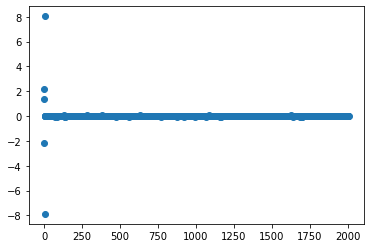

In [8]:
plt.plot(np.arange(len(fit1[1])), fit1[1], 'o')
plt.show()